## Sales_Forecasting_m5 - LSTM_model
Purpose:
Model nonlinear temporal patterns in weekly sales and compare against SARIMA & Prophet.

In [3]:
! pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/331.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/331.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/331.8 MB 2.4 MB/s eta 0:02:18
   ---------------------------------------- 0.8/331.8 MB 1.7 MB/s eta 0:03:18
   ---------------------------------------- 0.8/331.8 MB 1.7 MB/s eta 0:03:18
   ---------------------------------------- 1.0/331.8 MB 898.8 kB/s 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Step 5.1 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\Jacy Heather\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [5]:
# Step 5.2 Load processed data
store_daily_sales = pd.read_csv(
    "../data/processed/store_daily_sales.csv",
    parse_dates=["date"]
)

In [6]:
# Step 5.3 Filter one store & aggregate weekly
store_id = "CA_1"

store_ts = (
    store_daily_sales
    [store_daily_sales["store_id"] == store_id]
    .set_index("date")
)

weekly_sales = store_ts["sales"].resample("W").sum()

In [7]:
# Step 5.4 Train–test split (time-aware)
train_size = int(len(weekly_sales) * 0.8)

train = weekly_sales.iloc[:train_size]
test = weekly_sales.iloc[train_size:]

In [8]:
# Step 5.5 Scale data (LSTM is sensitive to scale)
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [9]:
# Step 5.6 Create sequences
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 12

X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

In [10]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Step 5.7 Build LSTM model
model = Sequential([
    LSTM(50, activation="tanh", input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


c:\Users\Jacy Heather\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 5.8 Train with early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1412 - val_loss: 0.0052
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0194 - val_loss: 0.0086
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0086 - val_loss: 0.0135
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

In [13]:
# Step 5.9 Forecast on test set
predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


In [14]:
# Step 5.10 Evaluate performance
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1442.17
RMSE: 1831.50


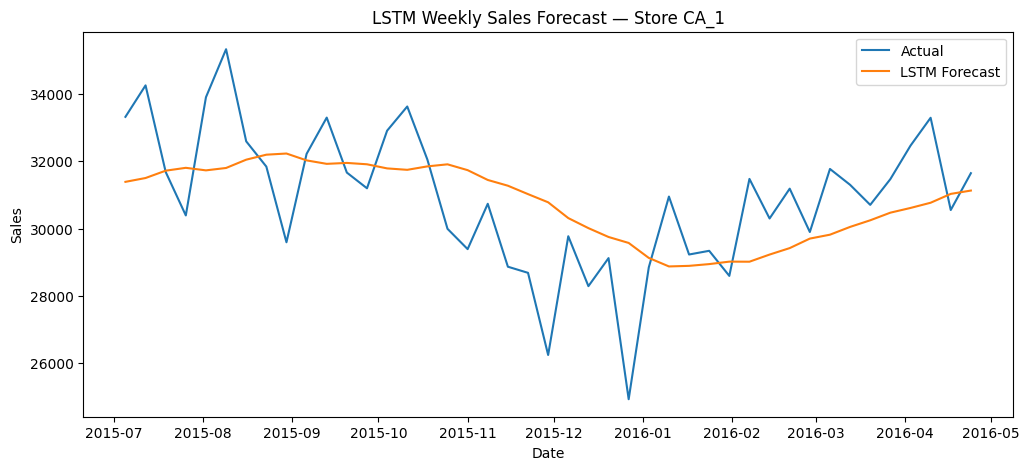

In [15]:
# Step 5.11 Plot forecast vs actual
test_dates = test.index[window_size:]

plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_test_actual, label="Actual")
plt.plot(test_dates, predictions, label="LSTM Forecast")
plt.title(f"LSTM Weekly Sales Forecast — Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

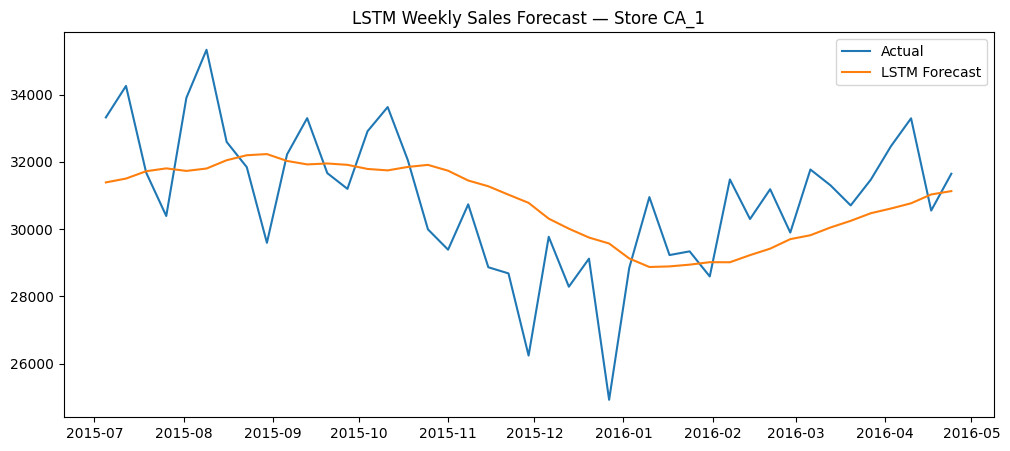

In [16]:
# Step 5.12 Save key visualization
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_test_actual, label="Actual")
plt.plot(test_dates, predictions, label="LSTM Forecast")
plt.title(f"LSTM Weekly Sales Forecast — Store {store_id}")
plt.legend()

plt.savefig(
    "../visuals/lstm_forecast_CA_1.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()